# Вариант Решения Тестового Задания:

## Стратегия:


1. [Изучить исходный файл с данными.](#intro)

2. [Подготовить данные для анализа.](#data_prep)

3. [Предварительный анализ данных и визуализация.](#data_analysis)

4. [Классифицировать дни.](#data_classification)

5. [Написать финальную версию функции Python, которая для конкретного пользователя берет его историю шагов и на выходе отдает список размеченных дней: неизвестно, обычный или необычный.](#final_solution)



### 1. Изучение исходного файла с сырыми данными <a name="intro"></a>

Для начала необходимо импортировать библиотеки Python, которые понадобятся для обработки данных:

In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from pylab import *
%matplotlib inline

plt.style.use('seaborn')
import seaborn as sns

from sklearn import preprocessing

print('Libraries imported.')

Libraries imported.


Создадим Dataframe с сырыми данными:

In [2]:
df_raw = pd.read_csv("https://www.dropbox.com/s/wc0r4muzezw6fhm/query_result_2019-12-24T07_29_06.659397Z.csv?dl=1")

Первые 5 строк данных:

In [3]:
df_raw.head()

,Time End,Time End Local Tz,Time Offset,Time Start,Time Start Local Tz,User ID,Value
0,2019-05-05T09:40:00+03:00,2019-05-05T12:40:00+03:00,10800,2019-05-05T09:39:59+03:00,2019-05-05T12:39:59+03:00,2166,1.0
1,2019-05-05T11:13:29+03:00,2019-05-05T14:13:29+03:00,10800,2019-05-05T11:12:51+03:00,2019-05-05T14:12:51+03:00,2166,34.0
2,2019-05-05T12:07:42+03:00,2019-05-05T15:07:42+03:00,10800,2019-05-05T12:07:39+03:00,2019-05-05T15:07:39+03:00,2166,1.0
3,2019-05-05T13:04:05+03:00,2019-05-05T16:04:05+03:00,10800,2019-05-05T13:04:02+03:00,2019-05-05T16:04:02+03:00,2166,3.0
4,2019-05-05T13:18:18+03:00,2019-05-05T16:18:18+03:00,10800,2019-05-05T13:18:13+03:00,2019-05-05T16:18:13+03:00,2166,6.0


Проверим нет ли null значений:

In [4]:
df_raw.isnull().values.any()

False

Общее количество строк (размер dataframe):

In [5]:
df_raw.shape

(39671, 7)

Сохраним значение количества строк в переменной **n**:

In [6]:
n = len(df_raw.index)
print(n)

39671


Первое, что можно заметить: данные поделены на отрезки, в которых подсчитаны шаги. Однако, данные о времени начала и конца каждого отрезка представлены в двух колонках, например: Time Start и Time Start Local Tz. 
Я буду использовать только второе значение, т.е. время по локальному часовому поясу пользователя.

Формат времени дан в стандарте ISO-8601.

Для того, чтобы на примере одного значения времени, посмотреть, как из этих данных извлекать отдельные (день, месяц, час и т.д.), можно выбрать данные первой строки с указанием формата:

In [7]:
example_date = datetime.datetime.strptime(df_raw['Time End'][0], "%Y-%m-%dT%H:%M:%S+03:00")

In [8]:
print(example_date)
print('Type: ',type(example_date))

2019-05-05 09:40:00
Type:  <class 'datetime.datetime'>


In [9]:
print('Month: ', example_date.month) 
print('Year: ', example_date.year) 
print('Hour: ', example_date.hour)
print('Minute: ', example_date.minute)

Month:  5
Year:  2019
Hour:  9
Minute:  40


### 1. Подготовка данных для анализа <a name="data_prep"></a>

Итак, для начала мне необходимо создать датафрейм с данными, которые нужно извлечь из дат начала и конца отрезков.
Для этого создадим новую dataframe **df** и добавим столбцы с данными о: 
* Начало отрезка даты в формате, из которого извлекаются внутренние данные. 
* Конец отрезка даты 

А также данные о начале и конце отрезка:

* Месяц 

* День 

* Час 

* Минута

* Секунда


In [10]:
df = df_raw.copy()

df["START"] = ""
df["END"] = ""

df["MONTH_start"] = ""
df["MONTH_end"] = ""

df["DAY_start"] = ""
df["DAY_end"] = ""

df["HOUR_start"] = ""
df["HOUR_end"] = ""

df["MINUTE_start"] = ""
df["MINUTE_end"] = ""

df["SECOND_start"] = ""
df["SECOND_end"] = ""

Удалим данные, которые на данный момент не явялются необходимыми:

In [11]:
df = df.drop(['User ID','Time End', 'Time Offset', 'Time Start'], axis=1)
df.head(1)

,Time End Local Tz,Time Start Local Tz,Value,START,END,MONTH_start,MONTH_end,DAY_start,DAY_end,HOUR_start,HOUR_end,MINUTE_start,MINUTE_end,SECOND_start,SECOND_end
0,2019-05-05T12:40:00+03:00,2019-05-05T12:39:59+03:00,1.0,,,,,,,,,,,,


In [12]:
for i in range(n):
    df['START'][i] = datetime.datetime.strptime(df['Time Start Local Tz'][i][:19], "%Y-%m-%dT%H:%M:%S")
    df['END'][i] = datetime.datetime.strptime(df['Time End Local Tz'][i][:19], "%Y-%m-%dT%H:%M:%S")
    
    df['MONTH_start'][i] = df['START'][i].month
    df['MONTH_end'][i] = df['END'][i].month
    
    df['DAY_start'][i] = df['START'][i].day
    df['DAY_end'][i] = df['END'][i].day
    
    df['HOUR_start'][i] = df['START'][i].hour
    df['HOUR_end'][i] = df['END'][i].hour
    
    df['MINUTE_start'][i] = df['START'][i].minute
    df['MINUTE_end'][i] = df['END'][i].minute
    
    df['SECOND_start'][i] = df['START'][i].second
    df['SECOND_end'][i] = df['END'][i].second

In [13]:
df = df.drop(['Time End Local Tz', 'Time Start Local Tz'], axis=1) 

In [14]:
df.head(1)

,Value,START,END,MONTH_start,MONTH_end,DAY_start,DAY_end,HOUR_start,HOUR_end,MINUTE_start,MINUTE_end,SECOND_start,SECOND_end
0,1.0,2019-05-05 12:39:59,2019-05-05 12:40:00,5,5,5,5,12,12,39,40,59,0


Добавим столбец "уникальный день".

Так как дни не повторяются (все данные содержат содержат информацию с 2019 года, уникальным днем будет "месяц-день").

И так как видно из первых 40 строк, что дни представлены в dataframe не по порядку, я хочу записывать комбинации "месяц и день" в цифровом формате, чтобы иметь возможность потом их отсортировать.
То есть комбинация будет выглядеть так:
(месяц)*100 + день

Например:
5 мая = 5*100 + 5 = 505 

Или 23 июня = 6100 + 23 = 623 

In [15]:
df['UNIQUE_DAY'] = df['MONTH_start']*100 + df['DAY_start']

Добавим столбец, в котором будут храниться значения интервала измеренного отрезка в секундах:

In [16]:
df['INTERVAL_sec'] = ""

for i in range(n):
    if (df['HOUR_end'][i] - df['HOUR_start'][i]) < 0:
        hour_diff = df['HOUR_end'][i] - df['HOUR_start'][i] + 24
    else:
        hour_diff = df['HOUR_end'][i] - df['HOUR_start'][i]
    min_diff = df['MINUTE_end'][i] - df['MINUTE_start'][i]
    sec_diff = df['SECOND_end'][i] - df['SECOND_start'][i]
    
    df['INTERVAL_sec'][i] = hour_diff*3600 + min_diff*60 + sec_diff

In [17]:
df['INTERVAL_sec'].describe()

count     39671
unique      611
top           3
freq       8229
Name: INTERVAL_sec, dtype: int64

Добавим столбец скорости в **шагах в секунду** для каждого дня:

In [18]:
df["STEPS_per_sec"] = ""
df["STEPS_per_sec"] = df["Value"]/df["INTERVAL_sec"]
df.head(1)

,Value,START,END,MONTH_start,MONTH_end,DAY_start,DAY_end,HOUR_start,HOUR_end,MINUTE_start,MINUTE_end,SECOND_start,SECOND_end,UNIQUE_DAY,INTERVAL_sec,STEPS_per_sec
0,1.0,2019-05-05 12:39:59,2019-05-05 12:40:00,5,5,5,5,12,12,39,40,59,0,505,1,1


In [19]:
df.head(1)

,Value,START,END,MONTH_start,MONTH_end,DAY_start,DAY_end,HOUR_start,HOUR_end,MINUTE_start,MINUTE_end,SECOND_start,SECOND_end,UNIQUE_DAY,INTERVAL_sec,STEPS_per_sec
0,1.0,2019-05-05 12:39:59,2019-05-05 12:40:00,5,5,5,5,12,12,39,40,59,0,505,1,1


Создадим столбцы со значениями начала и конца отрезвка в секундах:

In [20]:
df['time_start'] = ""
df['time_end'] = ""

df['time_start'] = df['HOUR_start']*3600 + df['MINUTE_start']*60 + df['SECOND_start']
df['time_end'] =  df['time_start'] + df['INTERVAL_sec']
    

In [21]:
df.head(1)

,Value,START,END,MONTH_start,MONTH_end,DAY_start,DAY_end,HOUR_start,HOUR_end,MINUTE_start,MINUTE_end,SECOND_start,SECOND_end,UNIQUE_DAY,INTERVAL_sec,STEPS_per_sec,time_start,time_end
0,1.0,2019-05-05 12:39:59,2019-05-05 12:40:00,5,5,5,5,12,12,39,40,59,0,505,1,1,45599,45600


Создадим столбец, в котором будем хранить разницу в секундах, если отрезок включал в себя полночь. Данная разница равна количеству секунд, которые уже относятся к следующему дню:

In [22]:
df['DAY_diff'] = ""
df['DAY_diff'] = (86400 - df['time_end'])
df_diff = df.loc[df['DAY_diff'] < 0].reset_index(drop = True)
df_diff.head(1)

,Value,START,END,MONTH_start,MONTH_end,DAY_start,DAY_end,HOUR_start,HOUR_end,MINUTE_start,MINUTE_end,SECOND_start,SECOND_end,UNIQUE_DAY,INTERVAL_sec,STEPS_per_sec,time_start,time_end,DAY_diff
0,14.0,2019-08-05 23:57:41,2019-08-06 00:00:05,8,8,5,6,23,0,57,0,41,5,805,144,0.0972222,86261,86405,-5


In [23]:
df.head(1)

,Value,START,END,MONTH_start,MONTH_end,DAY_start,DAY_end,HOUR_start,HOUR_end,MINUTE_start,MINUTE_end,SECOND_start,SECOND_end,UNIQUE_DAY,INTERVAL_sec,STEPS_per_sec,time_start,time_end,DAY_diff
0,1.0,2019-05-05 12:39:59,2019-05-05 12:40:00,5,5,5,5,12,12,39,40,59,0,505,1,1,45599,45600,40800


In [24]:
diff_days = df_diff.shape[0]
print(diff_days)

7


Теперь необходимо разделить отрезки, включающие в себя полночь на 2 отрезка и пропорционально (по средней скорости шагов в секунду) распределить между этими отрезками количество шагов. Тогда наши данные станут чище и можно будет рассматривать каждые сутки по отдельности. 

In [25]:
# Функция вставки строки
# source = https://www.geeksforgeeks.org/insert-row-at-given-position-in-pandas-dataframe/
def Insert_row(row_number, df, row_value): 
    # Starting value of upper half 
    start_upper = 0
   
    # End value of upper half 
    end_upper = row_number 
   
    # Start value of lower half 
    start_lower = row_number 
   
    # End value of lower half 
    end_lower = df.shape[0] 
   
    # Create a list of upper_half index 
    upper_half = [*range(start_upper, end_upper, 1)] 
   
    # Create a list of lower_half index 
    lower_half = [*range(start_lower, end_lower, 1)] 
   
    # Increment the value of lower half by 1 
    lower_half = [x.__add__(1) for x in lower_half] 
   
    # Combine the two lists 
    index_ = upper_half + lower_half 
   
    # Update the index of the dataframe 
    df.index = index_ 
   
    # Insert a row at the end 
    df.loc[row_number] = row_value 
    
    # Sort the index labels 
    df = df.sort_index() 
   
    # return the dataframe 
    return df 

In [26]:
new_df = df.copy()


limit = n
i = 0


while (i < limit):
    
    if (new_df['DAY_diff'][i] < 0):
        
        
        
        DAY_end = new_df['DAY_end'][i]
        new_df['DAY_end'][i] = new_df['DAY_start'][i]
        HOUR_end = new_df['HOUR_end'][i]
        new_df['HOUR_end'][i] = 0
        MINUTE_end = new_df['MINUTE_end'][i]
        new_df['MINUTE_end'][i] = 0
        SECOND_end = new_df['SECOND_end'][i]
        new_df['SECOND_end'][i] = 0
        time_end = new_df['time_end'][i]
        new_df['time_end'][i] = 86400
        new_df['Value'][i] = new_df['STEPS_per_sec'][i]*(86400 - new_df['time_start'][i])
        new_df['INTERVAL_sec'][i] = 86400 - new_df['time_start'][i]
        
        
        
        row_number = i + 1
        row_value = [new_df['STEPS_per_sec'][i]*(time_end - 86400), 
                               0,
                               0,
                               new_df['MONTH_start'][i],
                               new_df['MONTH_end'][i],
                               DAY_end,
                               DAY_end,
                               0,
                               HOUR_end,
                               0,
                               MINUTE_end,
                               0,
                               SECOND_end,
                               new_df['UNIQUE_DAY'][i] + 1,
                               time_end - 86400,
                               new_df['STEPS_per_sec'][i],
                               0,
                               time_end - 86400,
                               new_df['DAY_diff'][i]]

        new_df = Insert_row(row_number, new_df, row_value)
        limit += 1
        i += 2
    else:
        i += 1

    

#### Проверим, првильно ли добавились строки:

In [27]:
new_df[new_df['DAY_diff'] < 0]

,Value,START,END,MONTH_start,MONTH_end,DAY_start,DAY_end,HOUR_start,HOUR_end,MINUTE_start,MINUTE_end,SECOND_start,SECOND_end,UNIQUE_DAY,INTERVAL_sec,STEPS_per_sec,time_start,time_end,DAY_diff
5749,13.513889,2019-08-05 23:57:41,2019-08-06 00:00:05,8,8,5,5,23,0,57,0,41,0,805,139,0.0972222,86261,86400,-5
5750,0.486111,0,0,8,8,6,6,0,0,0,0,0,5,806,5,0.0972222,0,5,-5
11539,4393.925785,2019-08-04 22:40:05,2019-08-05 02:45:46,8,8,4,4,22,0,40,0,5,0,804,4795,0.916356,81605,86400,-9946
11540,9114.074215,0,0,8,8,5,5,0,2,0,45,0,46,805,9946,0.916356,0,9946,-9946
11903,50.237288,2019-08-07 23:59:21,2019-08-08 00:00:20,8,8,7,7,23,0,59,0,21,0,807,39,1.28814,86361,86400,-20
11904,25.762712,0,0,8,8,8,8,0,0,0,0,0,20,808,20,1.28814,0,20,-20
16100,1.700000,2019-07-15 23:59:59,2019-07-16 00:00:19,7,7,15,15,23,0,59,0,59,0,715,1,1.7,86399,86400,-19
16101,32.300000,0,0,7,7,16,16,0,0,0,0,0,19,716,19,1.7,0,19,-19
19778,1.352941,2019-06-05 23:59:59,2019-06-06 00:00:16,6,6,5,5,23,0,59,0,59,0,605,1,1.35294,86399,86400,-16
19779,21.647059,0,0,6,6,6,6,0,0,0,0,0,16,606,16,1.35294,0,16,-16


In [28]:
new_df.shape

(39678, 19)

In [29]:
df_final = new_df.copy()
df_final = df_final.drop(['START', 'END', 'MONTH_start', 'MONTH_end', 'DAY_start', 'DAY_end', 'HOUR_start',
                         'HOUR_end', 'MINUTE_start', 'MINUTE_end', 'SECOND_start', 'SECOND_end', 'DAY_diff'], axis = 1)

### Финальная датафрейм:

In [30]:
df_final.head()

,Value,UNIQUE_DAY,INTERVAL_sec,STEPS_per_sec,time_start,time_end
0,1.0,505,1,1,45599,45600
1,34.0,505,38,0.894737,51171,51209
2,1.0,505,3,0.333333,54459,54462
3,3.0,505,3,1,57842,57845
4,6.0,505,5,1.2,58693,58698


In [31]:
df_final.dtypes

Value            float64
UNIQUE_DAY        object
INTERVAL_sec      object
STEPS_per_sec     object
time_start        object
time_end          object
dtype: object

In [32]:
df_final['UNIQUE_DAY'] = df_final['UNIQUE_DAY'].astype(int)
df_final['INTERVAL_sec'] = df_final['INTERVAL_sec'].astype(int)
df_final['STEPS_per_sec'] = df_final['STEPS_per_sec'].astype(float)
df_final['time_start'] = df_final['time_start'].astype(float)
df_final['time_end'] = df_final['time_end'].astype(float)
df_final.dtypes

Value            float64
UNIQUE_DAY         int32
INTERVAL_sec       int32
STEPS_per_sec    float64
time_start       float64
time_end         float64
dtype: object

### 3. Предварительный анализ данных и визуализация <a name="data_analysis"></a>

Итак,
чтобы для начала посчитать сколько шагов пользователь делает за один день, мне нужно сложить все подсчитанные шаги в отрезках каждого дня.

In [33]:
df_days = df_final.groupby(['UNIQUE_DAY'], sort=True).sum().reset_index()
df_days = df_days[['UNIQUE_DAY', 'Value']]
df_days.head()

,UNIQUE_DAY,Value
0,502,12977.0
1,503,17003.0
2,504,14312.0
3,505,11124.0
4,506,7467.0


In [34]:
df_days["Value"].describe()

count      104.000000
mean     15233.673077
std       6097.801721
min       5776.000000
25%      11692.750000
50%      14508.500000
75%      17268.750000
max      57646.925785
Name: Value, dtype: float64

In [35]:
df_days["Value"].median()

14508.5

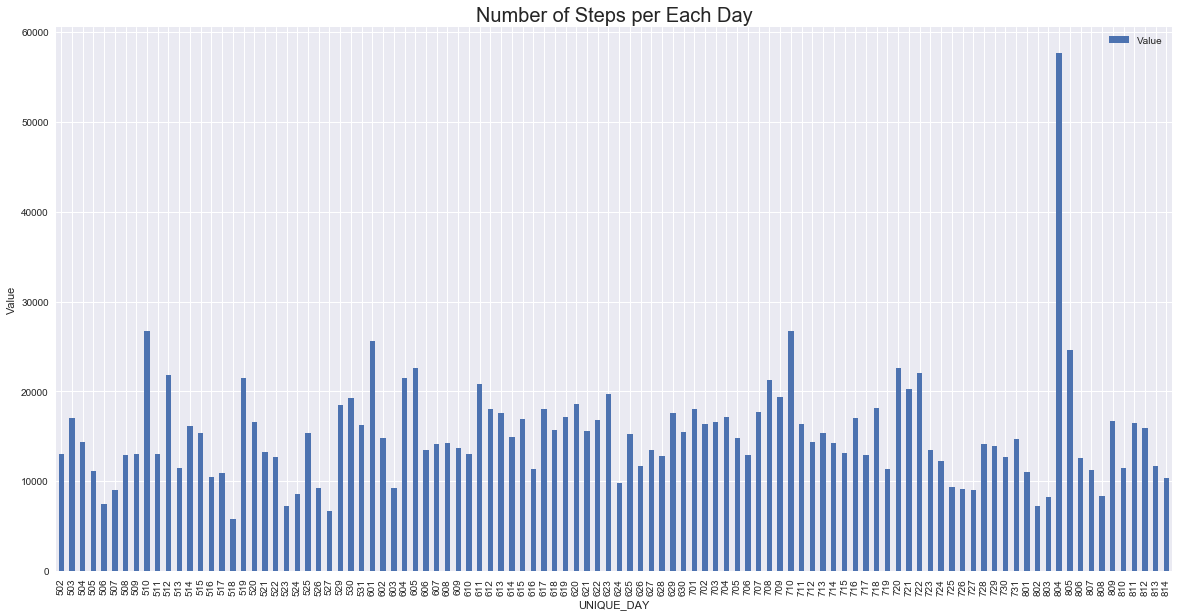

In [36]:
df_days.plot(x='UNIQUE_DAY', y='Value', kind='bar', figsize=(20, 10)) 

plt.xlabel('UNIQUE_DAY') 
plt.ylabel('Value') 
plt.title('Number of Steps per Each Day', fontsize = 20) 

plt.show()

### В среднем, данный пользователь делает около 14.5 тысяч шагов в день, однако бывали дни, когда шагов было минимум около 6 тысяч и максимум около 58 тысяч (что примерно в 4 раза превышает среднее значение за все три месяца). Из этих данных уже можно предположить, какой из дней по количеству шагов будет являться наиболее приближенным к категориям "обычных" и "необычных" дней. Однако, нас следует взглянуть на данные с разных ракурсов, чтобы принять во внимание и другие факторы.

Взглянем на частоту (скорость) в виде шагов в секунду в среднем и на каждый день:

In [119]:
df_freq = df_final[['UNIQUE_DAY', 'STEPS_per_sec']]
df_freq = df_freq.groupby(['UNIQUE_DAY'], sort=True).mean().reset_index()
df_freq.head()

,UNIQUE_DAY,STEPS_per_sec
0,502,0.964451
1,503,1.224208
2,504,1.247530
3,505,0.830735
4,506,0.931516


In [120]:
df_freq['STEPS_per_sec'].describe()

count    104.000000
mean       1.084262
std        0.235572
min        0.716466
25%        0.947533
50%        1.035382
75%        1.140981
max        2.114968
Name: STEPS_per_sec, dtype: float64

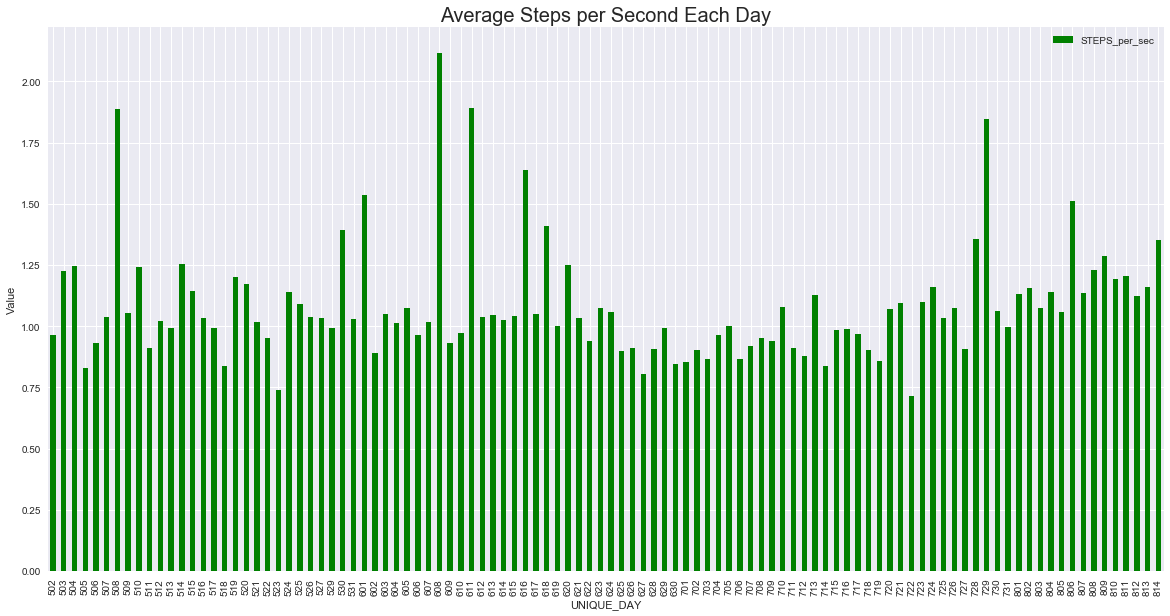

In [121]:
df_freq.plot(x='UNIQUE_DAY', y='STEPS_per_sec', kind='bar', figsize=(20, 10), color = 'green') 

plt.xlabel('UNIQUE_DAY') 
plt.ylabel('Value') 
plt.title('Average Steps per Second Each Day', fontsize = 20) 

plt.show()

### Из данных следует, что в среднем пользователь делает один шаг в секунду, однако в данном интервале 3 месяцев было немало дней, когда скорость шагов в секунду увеличивалась и уменьшалась, что также должно влиять на ощущения пользователя, насколько день был обычным, или нет.

Теперь создадим график количества времени (в секундах), в течение которого велись измерения каждый день. 

In [40]:
df_measurement_time = df_final.groupby(['UNIQUE_DAY'], sort=True).sum().reset_index()
df_measurement_time = df_measurement_time[['UNIQUE_DAY', 'INTERVAL_sec']]
df_measurement_time

,UNIQUE_DAY,INTERVAL_sec
0,502,20214
1,503,19143
2,504,14158
3,505,23977
4,506,12765
...,...,...
99,810,11685
100,811,16041
101,812,17566
102,813,14002


In [41]:
df_measurement_time["INTERVAL_sec"].describe()

count      104.000000
mean     20641.048077
std       8217.090966
min       7967.000000
25%      15701.000000
50%      20130.000000
75%      24401.750000
max      80548.000000
Name: INTERVAL_sec, dtype: float64

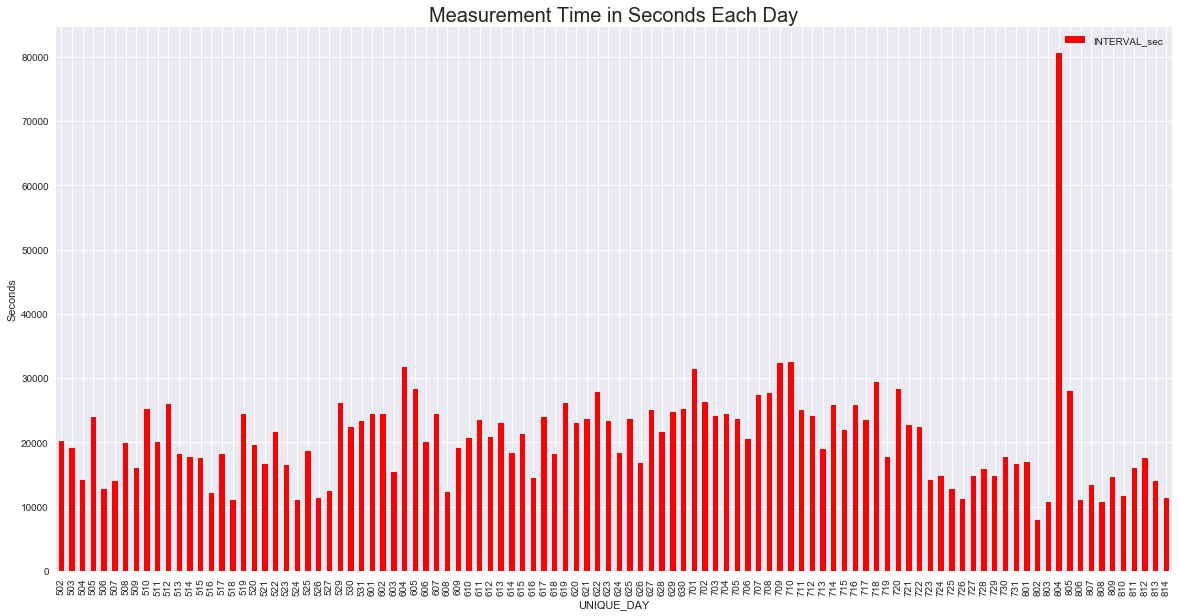

In [42]:
df_measurement_time.plot(x='UNIQUE_DAY', y='INTERVAL_sec', kind='bar', figsize=(20, 10), color = 'red') 

plt.xlabel('UNIQUE_DAY') 
plt.ylabel('Seconds') 
plt.title('Measurement Time in Seconds Each Day', fontsize = 20) 

plt.show()

### В среднем, как показывают данные в день измерения велись в течение 20641 сек = 5.7 часов. В те дни, когда измерения велись относительно короткое время либо, наоборот, на протяжении более долгого времени должны также рассматриваться для более точно классификации дней.

Разделим данные каждого дня на 10-минутные отрезки (600 секунд) и посмотрим на активность в течение дня по таким отрезкам:

In [43]:
days = df['UNIQUE_DAY'].unique()

In [44]:
num_days = len(df['UNIQUE_DAY'].unique())

In [45]:
df_bins = pd.DataFrame(index = [days],columns=np.arange(144)).sort_index()
df_bins = df_bins.T
df_bins.fillna(0, inplace=True)
df_bins.head()

,502,503,504,505,506,507,508,509,510,511,...,805,806,807,808,809,810,811,812,813,814
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
print(num_days)
new_n = df_final.shape[0]
print(new_n)

104
39678


Функция, которая запишет количество шагов каждый 10 минутный отрезок наших дней:

In [47]:
for i in range(new_n):
    day = df_final['UNIQUE_DAY'][i]
    time_start = df_final['time_start'][i]
    INTERVAL_sec = df_final['INTERVAL_sec'][i]
    STEPS_per_sec = df_final['STEPS_per_sec'][i]
    time_end = df_final['time_end'][i]
    Value = df_final['Value'][i]

    for k in range(num_days):
        if (day == df_bins.iloc[:,k].name[0]):
            
            start_loc = int(floor(time_start/600)) 
            end_loc = int(floor(time_end/600)) 
            if end_loc == 144:
                end_loc = 143
            
            if (end_loc > start_loc):
                df_bins.iloc[start_loc,k] = df_bins.iloc[start_loc,k] + round(((start_loc + 1)*600 - time_start)*STEPS_per_sec)

                df_bins.iloc[end_loc,k] = df_bins.iloc[end_loc,k] + round((time_end - end_loc*600)*STEPS_per_sec)                
            
                mid_locs = int((end_loc - start_loc) - 1)

                for j in range(1, mid_locs):
                    df_bins.iloc[start_loc + j,k] = 600*STEPS_per_sec
            else:
                df_bins.iloc[start_loc,k] = df_bins.iloc[start_loc,k] + round((time_end - time_start)*STEPS_per_sec)
            

In [48]:
df_bins.iloc[74,3]

52.0

In [49]:
#df_bins.iloc[:,3]

In [50]:
#df_bins.iloc[:,3].value_counts()

In [51]:
series = df_bins.iloc[:,3]
result = series.nonzero() 
values = series.iloc[result] 
values.head(30)

48     16.0
51     23.0
55    220.0
56    466.0
57    926.0
58    815.0
59     17.0
60    347.0
61    347.0
62     45.0
66     35.0
68      8.0
70     43.0
71     25.0
72     22.0
74     52.0
75    854.0
76     77.0
77      8.0
80      4.0
81     10.0
82     21.0
84     78.0
85    851.0
86    659.0
87    439.0
88    136.0
89     15.0
90     26.0
91      9.0
Name: (505,), dtype: float64

In [52]:
df_final[df_final['UNIQUE_DAY'] == 505].shape

(250, 6)

Можно проверить, что данные записались верно, взглянув на данные 5 мая:

In [53]:
df_final[df_final['UNIQUE_DAY'] == 505].sort_values(by=['time_start']).head(50)

,Value,UNIQUE_DAY,INTERVAL_sec,STEPS_per_sec,time_start,time_end
19316,8.0,505,398,0.020101,28800.0,29198.0
19317,1.0,505,3,0.333333,29198.0,29201.0
19318,7.0,505,198,0.035354,29201.0,29399.0
19268,5.0,505,8,0.625000,30962.0,30970.0
19319,18.0,505,229,0.078603,30970.0,31199.0
19320,50.0,505,335,0.149254,33000.0,33335.0
19321,43.0,505,51,0.843137,33335.0,33386.0
19322,37.0,505,54,0.685185,33386.0,33440.0
19323,41.0,505,59,0.694915,33440.0,33499.0
19324,31.0,505,54,0.574074,33499.0,33553.0


In [54]:
df_bins.head()

,502,503,504,505,506,507,508,509,510,511,...,805,806,807,808,809,810,811,812,813,814
0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,550.000000,0.0,0.0,389.0,0.0,10.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,549.813445,0.0,0.0,74.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,549.813445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,549.813445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,549.813445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
df_bins1 = df_bins.copy()
df_bins1['AVERAGE'] = df_bins1.mean(numeric_only=True, axis=1)
df_bins1 = df_bins1[['AVERAGE']]

In [56]:
df_bins1.max()

AVERAGE    251.751812
dtype: float64

# Средняя активность (количество шагов в промежутках в 10 минут в течение суток):

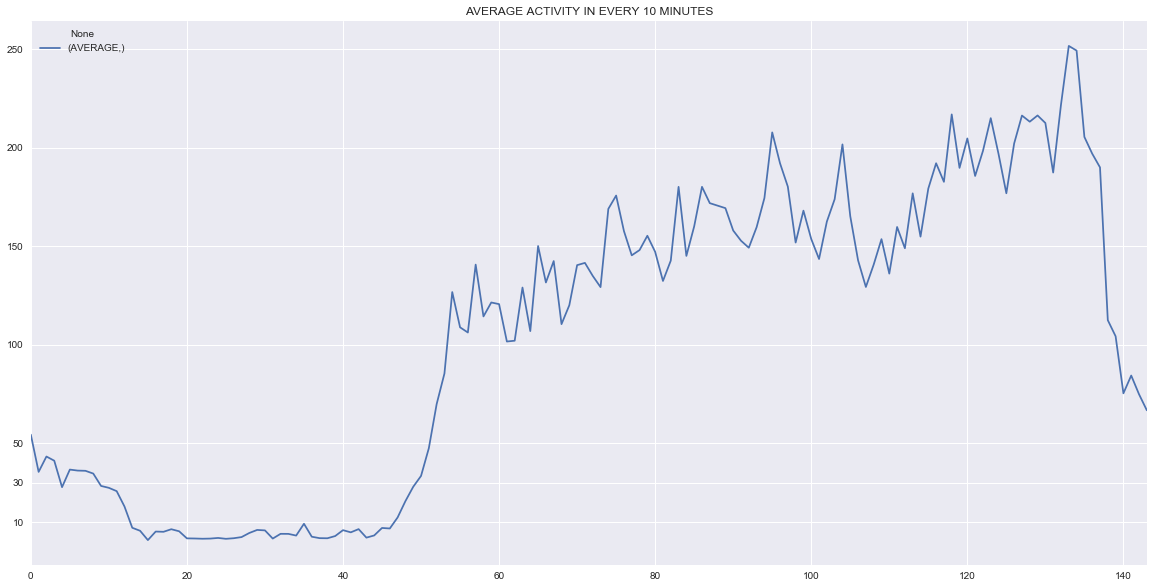

In [57]:
p1 = df_bins1.plot(kind='line', title='AVERAGE ACTIVITY IN EVERY 10 MINUTES', yticks=[10, 30, 50, 100, 150, 200, 250], figsize=(20, 10))

Можно также просмотреть активность в течение любого дня в датафрейм. Например, 2 мая активность выглядел так:

In [58]:
#p1 = df_bins.iloc[:,0].plot(kind='line', title='AVERAGE ACTIVITY IN EVERY 10 MINUTES', yticks=[10, 30, 50, 100, 150, 200, 250, 500, 1000], figsize=(20, 10))

Средняя активность в отрезки длиной 10 минут могут быть слишком подробными, поэтому возьмем получасовые отрезки, чтобы увидеть активность пользователя каждые 30 минут:

In [59]:
df_30min= pd.DataFrame(index = [days],columns=np.arange(48)).sort_index()
df_30min = df_30min.T
df_30min.fillna(0, inplace=True)

In [60]:
for i in range(new_n):
    day = df_final['UNIQUE_DAY'][i]
    time_start = df_final['time_start'][i]
    INTERVAL_sec = df_final['INTERVAL_sec'][i]
    STEPS_per_sec = df_final['STEPS_per_sec'][i]
    time_end = df_final['time_end'][i]
    Value = df_final['Value'][i]

    for k in range(num_days):
        if (day == df_30min.iloc[:,k].name[0]):
            
            start_loc = int(floor(time_start/1800)) 
            end_loc = int(floor(time_end/1800)) 
            if end_loc == 48:
                end_loc = 47
            
            if (end_loc > start_loc):

                df_30min.iloc[start_loc,k] = df_30min.iloc[start_loc,k] + round(((start_loc + 1)*1800 - time_start)*STEPS_per_sec)

                df_30min.iloc[end_loc,k] = df_30min.iloc[end_loc,k] + round((time_end - end_loc*1800)*STEPS_per_sec)                
            
                mid_locs = int((end_loc - start_loc) - 1)

                for j in range(1, mid_locs):
                    df_30min.iloc[start_loc + j,k] = 1800*STEPS_per_sec
            else:
                df_30min.iloc[start_loc,k] = df_30min.iloc[start_loc,k] + round((time_end - time_start)*STEPS_per_sec)

In [61]:
df_30min1 = df_30min.copy()
df_30min1['AVERAGE'] = df_30min1.mean(numeric_only=True, axis=1)
df_30min1 = df_30min1[['AVERAGE']]
df_30min1.max()

AVERAGE    686.471154
dtype: float64

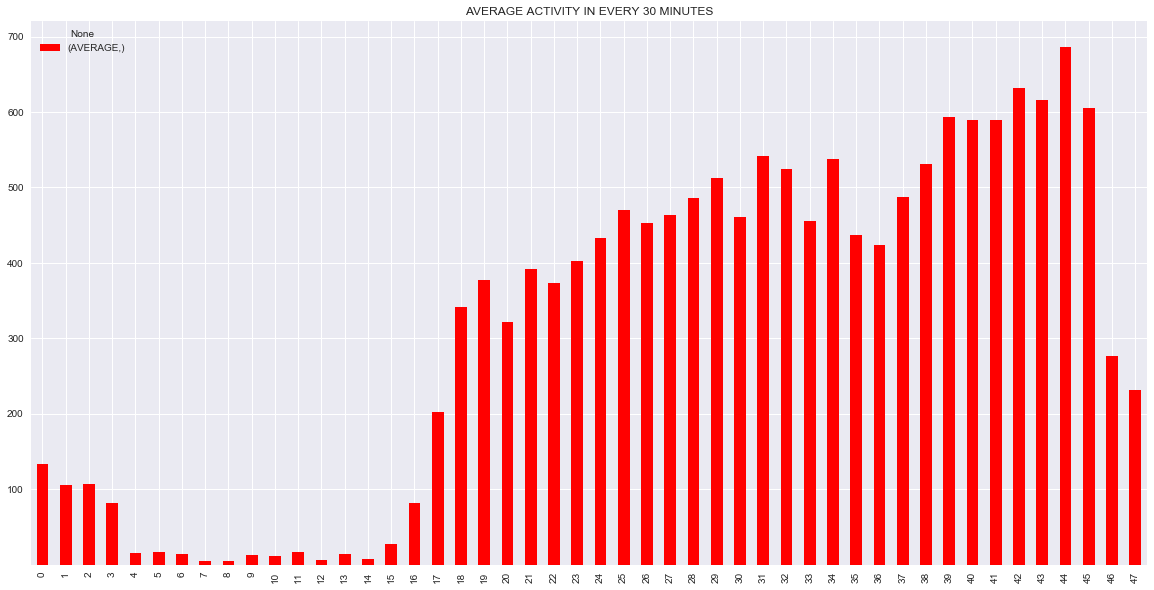

In [62]:
p2 = df_30min1.plot(kind='bar', title='AVERAGE ACTIVITY IN EVERY 30 MINUTES', yticks=[100, 200, 300, 400, 500, 600, 700], figsize=(20, 10), color = 'red')

In [63]:
#p5 = df_30min.iloc[:,0].plot(kind='bar', title='AVERAGE ACTIVITY IN EVERY 10 MINUTES', figsize=(20, 10))

In [64]:
df_bins1

,AVERAGE
0,54.423077
1,35.517437
2,43.315514
3,41.200129
4,27.757822
...,...
139,104.363591
140,75.392437
141,84.430899
142,74.923077


In [65]:
df_bins_diff = pd.DataFrame(index = [days],columns=np.arange(144)).sort_index()
df_bins_diff = df_bins_diff.T
df_bins_diff.fillna(0, inplace=True)
df_bins_diff.head()

,502,503,504,505,506,507,508,509,510,511,...,805,806,807,808,809,810,811,812,813,814
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
bins = df_bins.shape[0]
print(bins)

144


In [67]:
for i in range(bins):
    for j in range(num_days):
        df_bins_diff.iloc[i][j] = abs(df_bins.iloc[i][j] - df_bins1.iloc[i][0])

In [68]:
df_bins_diff

,502,503,504,505,506,507,508,509,510,511,...,805,806,807,808,809,810,811,812,813,814
0,33,54,54,54,54,54,54,54,54,54,...,495,54,54,334,54,44,54,54,54,54
1,35,35,35,35,35,35,35,35,35,35,...,514,35,35,38,35,35,35,35,35,35
2,43,43,43,43,43,43,43,43,43,43,...,506,43,43,43,43,43,43,43,43,43
3,41,41,41,41,41,41,41,41,41,41,...,508,41,41,41,41,41,41,41,41,41
4,27,27,27,27,27,27,27,27,27,27,...,522,27,27,27,27,27,27,27,27,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,104,104,104,50,104,104,104,104,104,104,...,206,104,8,104,66,104,104,102,104,104
140,45,75,75,75,75,75,75,75,75,75,...,281,75,17,75,156,75,75,75,75,75
141,84,84,84,84,84,84,84,84,303,84,...,238,84,507,84,56,84,84,84,84,84
142,74,74,74,74,74,74,74,74,386,74,...,3,74,713,74,63,74,74,74,74,74


In [69]:
df_bins_diff.loc['average']= df_bins_diff.mean()

In [70]:
df_bins_diff

,502,503,504,505,506,507,508,509,510,511,...,805,806,807,808,809,810,811,812,813,814
0,33.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000,54.000000,54.000000,...,495.000000,54.000000,54.000000,334.000,54.000000,44.000000,54.000000,54.000000,54.000000,54.000000
1,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000,35.000000,35.000000,...,514.000000,35.000000,35.000000,38.000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
2,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000,43.000000,43.000000,...,506.000000,43.000000,43.000000,43.000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000
3,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000,41.000000,41.000000,...,508.000000,41.000000,41.000000,41.000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
4,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000,27.000000,27.000000,...,522.000000,27.000000,27.000000,27.000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,45.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000,75.000000,75.000000,...,281.000000,75.000000,17.000000,75.000,156.000000,75.000000,75.000000,75.000000,75.000000,75.000000
141,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000,303.000000,84.000000,...,238.000000,84.000000,507.000000,84.000,56.000000,84.000000,84.000000,84.000000,84.000000,84.000000
142,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000,386.000000,74.000000,...,3.000000,74.000000,713.000000,74.000,63.000000,74.000000,74.000000,74.000000,74.000000,74.000000
143,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000,66.000000,66.000000,...,34.000000,66.000000,737.000000,66.000,35.000000,66.000000,66.000000,66.000000,66.000000,66.000000


In [71]:
df_bins_diff = df_bins_diff.T

In [72]:
df_bins_diff

,0,1,2,3,4,5,6,7,8,9,...,135,136,137,138,139,140,141,142,143,average
502,33.0,35.0,43.0,41.0,27.0,36.0,36.0,36.0,34.0,28.0,...,245.0,252.0,190.0,112.0,104.0,45.0,84.0,74.0,66.0,129.840278
503,54.0,35.0,43.0,41.0,27.0,36.0,36.0,36.0,34.0,28.0,...,205.0,197.0,190.0,112.0,104.0,75.0,84.0,74.0,66.0,148.611111
504,54.0,35.0,43.0,41.0,27.0,36.0,36.0,36.0,34.0,28.0,...,205.0,197.0,190.0,112.0,104.0,75.0,84.0,74.0,66.0,149.777778
505,54.0,35.0,43.0,41.0,27.0,36.0,36.0,36.0,34.0,28.0,...,166.0,194.0,171.0,89.0,50.0,75.0,84.0,74.0,66.0,110.916667
506,54.0,35.0,43.0,41.0,27.0,36.0,36.0,36.0,34.0,28.0,...,554.0,266.0,170.0,112.0,104.0,75.0,84.0,74.0,66.0,113.861111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
810,44.0,35.0,43.0,41.0,27.0,36.0,36.0,36.0,34.0,28.0,...,182.0,197.0,129.0,64.0,104.0,75.0,84.0,74.0,66.0,109.659722
811,54.0,35.0,43.0,41.0,27.0,36.0,36.0,36.0,34.0,28.0,...,205.0,197.0,190.0,112.0,104.0,75.0,84.0,74.0,66.0,140.618056
812,54.0,35.0,43.0,41.0,27.0,36.0,36.0,36.0,34.0,28.0,...,18.0,187.0,190.0,112.0,102.0,75.0,84.0,74.0,66.0,135.236111
813,54.0,35.0,43.0,41.0,27.0,36.0,36.0,36.0,34.0,28.0,...,205.0,197.0,190.0,112.0,104.0,75.0,84.0,74.0,66.0,115.291667


In [73]:
df_bins_diff = df_bins_diff[['average']]

In [74]:
df_bins_diff

,average
502,129.840278
503,148.611111
504,149.777778
505,110.916667
506,113.861111
...,...
810,109.659722
811,140.618056
812,135.236111
813,115.291667


In [75]:
df_bins_diff['average'].describe()

count    104.000000
mean     133.077858
std       23.684824
min       90.812500
25%      119.850694
50%      129.031250
75%      144.564236
max      276.125000
Name: average, dtype: float64

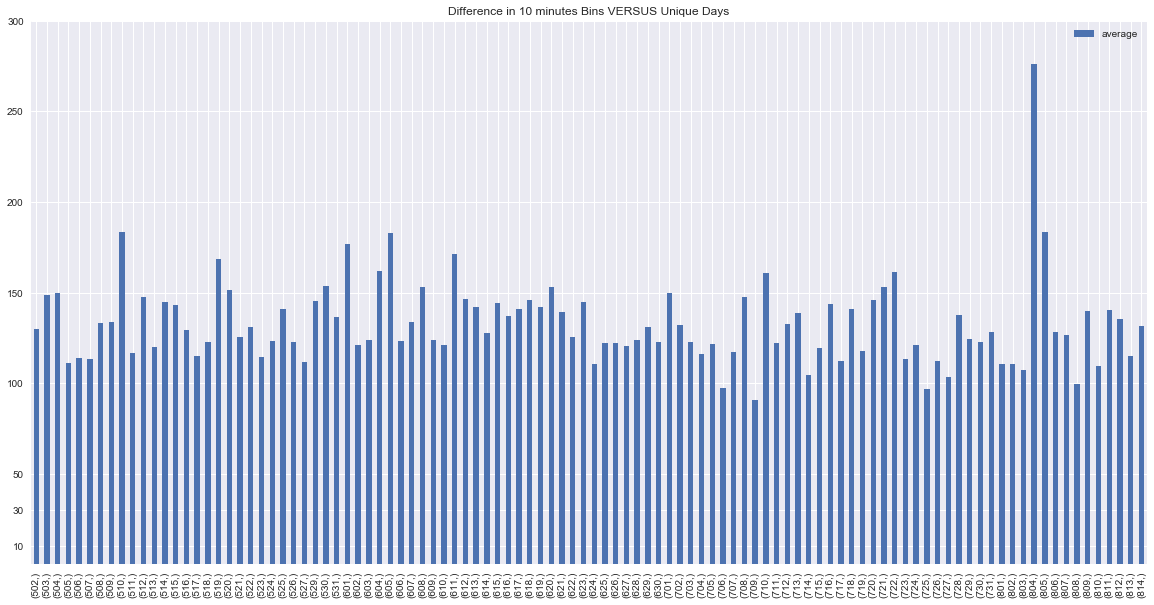

In [76]:
p3 = df_bins_diff.plot(kind='bar', title='Difference in 10 minutes Bins VERSUS Unique Days', yticks=[10, 30, 50, 100, 150, 200, 250, 300], figsize=(20, 10))

In [96]:
df_bins_diff['average'].describe()

count    104.000000
mean     133.077858
std       23.684824
min       90.812500
25%      119.850694
50%      129.031250
75%      144.564236
max      276.125000
Name: average, dtype: float64

### 4. Классификация данных <a name="data_classification"></a>

Главной задачей является классификация дней на три категории, совпадающая с ощущением самого пользователя:

1. Обычный день
2. Необыный день
3. Неизвестно


Как критерии для категоризации я буду использовать найденные ранее данные, а именно 4 признака и классифицировать каждый признак по группам: 1 - среднее значение для этого признака, 0 - находящееся в минимальном промежутке и 2 в максимальном:

1. Количество шагов в день 
2. Скорость (Количество шагов в секунду в день)
3. Продолжительность измерений в день (сумма интервалов отрезков)
4. Разница в активности в 10-минутных промежутках


Сама классификация будет основываться на следующем:

День классифицируется как **обычный**, если:

- В этот день отмечены близкое к срединному значению величины хотя бы в 2 признаках.

День классифицируется как **необычный**, если:

- В этот день были отмечены значительные отклонения от нормы (среднего знаения) хотя бы в 2 признаках.

День классифицируется как **неизвестный**, если:


- Величина в каком-либо признаке аномальна.
- В минимальный промежуток попадает продолжительность измерений. Как пользователь смарт часов, которые могут быть передатчиками подобных данных, я бы отнесла дни к категории "неизвестно", если в тот день измерения были непродолжительными.





Для начала создадим датафрейм для конечной классификации:

In [122]:
df_classify = pd.DataFrame(index = [days],columns=np.arange(5)).sort_index()
df_classify = df_classify.rename(columns = { 0: 'STEPS', 1:'STEPS_per_SEC', 2:'DURATION', 3: 'Difference', 4:'Category'})
df_classify.head(1)

,STEPS,STEPS_per_SEC,DURATION,Difference,Category
502,NaN,NaN,NaN,NaN,NaN


Заполним датафрейм данными. Для каждого признака 0, 1 или 2:

In [123]:
for i in range(num_days):
    if df_days.iloc[i]['Value'] < 11000:
        df_classify.iloc[i]['STEPS'] = 0
    elif df_days.iloc[i]['Value'] >= 11000 and df_days.iloc[i]['Value'] < 17000:
        df_classify.iloc[i]['STEPS'] = 1
    elif df_days.iloc[i]['Value'] >= 17000:
        df_classify.iloc[i]['STEPS'] = 2

In [124]:
df_classify['STEPS'].value_counts()

1    55
2    30
0    19
Name: STEPS, dtype: int64

In [125]:
for i in range(num_days):
    if df_freq.iloc[i]['STEPS_per_sec'] < 0.94:
        df_classify.iloc[i]['STEPS_per_SEC'] = 0
    elif df_freq.iloc[i]['STEPS_per_sec'] >= 0.94 and df_freq.iloc[i]['STEPS_per_sec'] < 1.14:
        df_classify.iloc[i]['STEPS_per_SEC'] = 1
    elif df_freq.iloc[i]['STEPS_per_sec'] >= 1.14:
        df_classify.iloc[i]['STEPS_per_SEC'] = 2

In [126]:
df_classify['STEPS_per_SEC'].value_counts()

1    51
2    27
0    26
Name: STEPS_per_SEC, dtype: int64

In [127]:
for i in range(num_days):
    if df_measurement_time.iloc[i]['INTERVAL_sec'] < 15000:
        df_classify.iloc[i]['DURATION'] = 0
    elif df_measurement_time.iloc[i]['INTERVAL_sec'] >= 15000 and df_measurement_time.iloc[i]['INTERVAL_sec'] < 25000:
        df_classify.iloc[i]['DURATION'] = 1
    elif df_measurement_time.iloc[i]['INTERVAL_sec'] >= 25000:
        df_classify.iloc[i]['DURATION'] = 2

In [128]:
df_classify['DURATION'].value_counts()

1    57
0    25
2    22
Name: DURATION, dtype: int64

In [129]:
for i in range(num_days):
    if df_bins_diff.iloc[i]['average'] < 130:
        df_classify.iloc[i]['Difference'] = 1
    elif df_bins_diff.iloc[i]['average'] >= 130 and df_bins_diff.iloc[i]['average'] < 145:
        df_classify.iloc[i]['Difference'] = 2
    elif df_bins_diff.iloc[i]['average'] >= 145:
        df_classify.iloc[i]['Difference'] = 3

In [130]:
df_classify['Difference'].value_counts()

1    54
2    26
3    24
Name: Difference, dtype: int64

In [144]:
df_classify.head(50)

,STEPS,STEPS_per_SEC,DURATION,Difference,Category
502,1,1,1,1,NaN
503,2,2,1,3,NaN
504,1,2,0,3,NaN
505,1,0,1,1,NaN
506,0,0,0,1,NaN
507,0,1,0,1,NaN
508,1,2,1,2,NaN
509,1,1,1,2,NaN
510,2,2,2,3,NaN
511,1,0,1,1,NaN


In [142]:
#(df_classify[['STEPS','STEPS_per_SEC','DURATION','Difference']] == 1).sum(axis=1)

In [ ]:
for i in range(num_days):
    if (df_classify[['STEPS','STEPS_per_SEC','DURATION','Difference']] == 1).sum(axis=1)[i] >= 2 and :
        df_classify.iloc[i]['Category'] = 'USUAL'
    elif :
        df_classify.iloc[i]['Category'] = 'UNUSUAL'
    elif (df_classify[['DURATION']] == 0).sum(axis=1)[i]:
        df_classify.iloc[i]['Category'] = 'UNKNOWN'

### 5. Функция PYTHON <a name="final_solution"></a>

In [134]:
# df_raw_data = 